<center><H1>Modelo para problema de regresión estática</H1><center>

<center><img src="https://www.gstatic.com/devrel-devsite/prod/ve2848ad92313fddfcd40baeb58a2f663fe2fd55c371a714a6bb3e329e2b15223/tensorflow/images/lockup.svg"  height="80px" style="padding-bottom:5px;"  /></center>

<center><H2>Julio Waissman Vilanova</H2>

<table align="center">
      <td align="center"><a target="_blank" href="https://www.unison.mx">
            <img src="https://www.unison.mx/wp-content/themes/awaken/images/logo.png"  height="70px" style="padding-bottom:5px;"  /></a></td>  
      <td align="center"><a target="_blank" href="https://www.gob.mx/cenace">
            <img src="https://universidad.cenace.gob.mx/pluginfile.php/244/block_html/content/CENACE-logo-completo.png" width="300" style="padding-bottom:5px;" /></a></td>
      <td align="center"><a target="_blank" href="https://colab.research.google.com/github/juliowaissman/rn-cenace/blob/main/taller_solar-resuelto.ipynb">
            <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Ejecuta en Google Colab</a></td>

</table>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('ggplot')

## Cargando los datos

Vamos a cargar los datos que nos proporcionó la Gerencia Regional Noroeste sobre una planta de generación de energía fotovoltáica y vamos a ver si somos capaces de predecir la Generación de energía utilizando la información de la Radiación, así como la información de la fecha.

In [9]:
url = "https://github.com/juliowaissman/curso-ml-cenace/raw/main/datos/Dataset_GeneracionFV.xlsx"
df = pd.read_excel(url, sheet_name=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5520 entries, 0 to 5519
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              5520 non-null   datetime64[ns]
 1   Generacion_FV_MW   5520 non-null   float64       
 2   Radiacion_FV_W/m2  5520 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 129.5 KB


In [52]:
df.index = df.Fecha
df['Hora'] = df.index.hour
df['Dia'] = df.index.day
df['Mes'] = df.index.month
df.rename(columns={'Radiacion_FV_W/m2': 'Radiacion_FV'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5520 entries, 2021-01-01 01:00:00 to 2021-08-19 00:00:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             5520 non-null   datetime64[ns]
 1   Generacion_FV_MW  5520 non-null   float64       
 2   Radiacion_FV      5520 non-null   float64       
 3   Hora              5520 non-null   int64         
 4   Dia               5520 non-null   int64         
 5   Mes               5520 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 301.9 KB


## Hagamos un pequeño análisis exploratorio de datos

<AxesSubplot:xlabel='Generacion_FV_MW', ylabel='Radiacion_FV'>

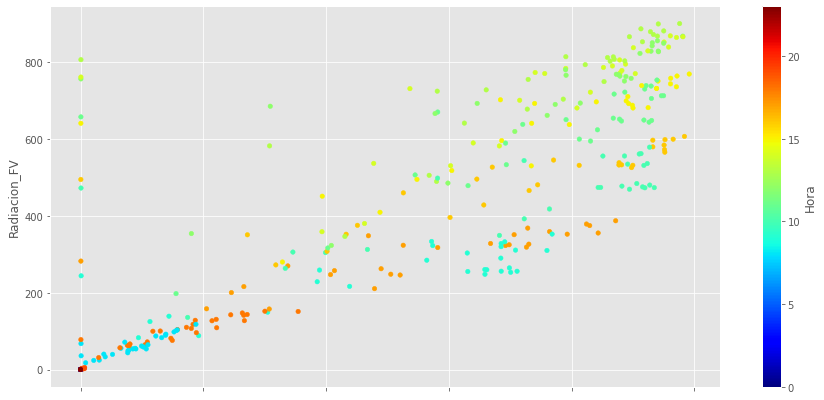

In [54]:
df[df.Mes == 2].plot.scatter(
    x='Generacion_FV_MW',
    y='Radiacion_FV',
    #s='Dia',
    c='Hora',
    colormap='jet',
    figsize=(15,7)
)

Al parecer hay varios valores aberrantes que deberíamos limpiar para hacer una predicción, por el momento vamos a dejarlos y regresaremos con la limpieza en un segundo término

In [51]:
df.query('Radiacion_FV > 20 and Generacion_FV_MW < .5').Dia.value_counts()

1    34
0    25
2    21
3    20
4    18
6    15
5     3
Name: Dia, dtype: int64

## Predicción de la generación usando redes neuronales

Para este problema vamos a ir desarrollando el problema paso a paso.

Para esto vamos a hacer algunas hipótesis:

- El problema es estático: la generación de energía va a depender sólo de la radiación en el mismo momento, la hora del día, el día del mes y el mes del año.

- Los datos como hora, día y mes los vamos a codificar directamente, y luego veremos como funciona con one-hot encoding

- Vamos aprobar primero si sólo con la radiación es posible generalizar algo decente.


### Paso 1: Seleccionar los datos y separar en conjunto de datos de entrenamiento y conjunto de datos de prueba

In [64]:
x = df.Radiacion_FV.to_numpy()
y = df.Generacion_FV_MW.to_numpy()

#TODO: Al terminar de hacer el modelo 
#    con solo una entrada y una salida, probar 
#    agregar otras variables y documentar

print(f"La forma de x: {x.shape} y la de y = {y.shape}")

#TODO: Separa en un conjunto de prueba y otro de test
#      (decide cuanto usar para cada uno)

indices = list(range(x.shape[0]))
np.random.shuffle(indices)

x_train = x[indices[520:]].reshape(-1,1)
y_train = y[indices[520:]]
x_test = x[indices[:520]].reshape(-1,1)
y_test = y[indices[:520]]

La forma de x: (5520,) y la de y = (5520,)


### Paso 2: definir una red neuronal 

Recuerda que solo tenemos 5000 datos de entrenamiento (de ser posible, el número de parámetros menor a 10 veces el número de datos de entrenamiento)

In [74]:
def modelo_sin_compil(nombre="Solar_1"):
    modelo = keras.models.Sequential(name=nombre)

    #TODO: ajusta un modelo
    modelo.add(layers.Dense(10, activation="sigmoid", input_shape=(1,), name="capa_1"))
    modelo.add(layers.Dense(30, activation="sigmoid", name="capa_2"))
    modelo.add(layers.Dense(1, activation="linear", name="capa_3"))
    return modelo

modelo = modelo_sin_compil()

modelo.summary()

Model: "Solar_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 10)                20        
_________________________________________________________________
capa_2 (Dense)               (None, 30)                330       
_________________________________________________________________
capa_3 (Dense)               (None, 1)                 31        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


### Paso 3 Compila el modelo

Selecciona los parámetros que creas más convenientes

In [75]:
def modelo_compilado():
    model = modelo_sin_compil()
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.MeanAbsoluteError(),
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model

modelo = modelo_compilado()

### Paso 4 Entrena el modelo

Vamos a repetir este paso mientras parezca que no hay sobreaprendizaje (vamos a hacer el early stoping a mano en este caso)

In [85]:
num_epochs = 20
print(f"Entrenamiento del modelo en {num_epochs} epochs")

history = modelo.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=num_epochs,
    validation_split=0.2 # Porcentaje de datos para usar como validación
)

Entrenamiento del modelo en 20 epochs
Epoch 1/20
63/63 [==============================] - 0s 2ms/step - loss: 7.0911 - mean_absolute_error: 7.0911 - val_loss: 6.7227 - val_mean_absolute_error: 6.7227
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 7.1198 - mean_absolute_error: 7.1198 - val_loss: 6.7537 - val_mean_absolute_error: 6.7537
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 7.0382 - mean_absolute_error: 7.0382 - val_loss: 6.7582 - val_mean_absolute_error: 6.7582
Epoch 4/20
63/63 [==============================] - 0s 1ms/step - loss: 6.9372 - mean_absolute_error: 6.9372 - val_loss: 6.6963 - val_mean_absolute_error: 6.6963
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 6.9279 - mean_absolute_error: 6.9279 - val_loss: 6.6294 - val_mean_absolute_error: 6.6294
Epoch 6/20
63/63 [==============================] - 0s 1ms/step - loss: 6.8272 - mean_absolute_error: 6.8272 - val_loss: 6.6406 - val_mean_absolute_erro

In [86]:
print(pd.DataFrame(history.history))

        loss  mean_absolute_error  val_loss  val_mean_absolute_error
0   7.091053             7.091053  6.722714                 6.722714
1   7.119782             7.119782  6.753742                 6.753742
2   7.038234             7.038234  6.758224                 6.758224
3   6.937232             6.937232  6.696316                 6.696316
4   6.927870             6.927870  6.629445                 6.629445
5   6.827165             6.827165  6.640611                 6.640611
6   6.866444             6.866444  6.703901                 6.703901
7   6.806214             6.806214  6.539221                 6.539221
8   6.693678             6.693678  6.508838                 6.508838
9   6.886657             6.886657  6.888490                 6.888490
10  6.713346             6.713346  6.485542                 6.485542
11  6.650621             6.650621  6.477708                 6.477708
12  6.706291             6.706291  6.464439                 6.464439
13  6.888964             6.888964 

### Paso 5 Evalúa con los datos de prueba

Este paso se ejecuta sólamente si el valor de pérdida y de las métricas se consideran aceptables. Si no es necesario buscar nuevos modelos.

In [88]:
print("Evaluando en los datos de prueba")

results = modelo.evaluate(x_test, y_test, batch_size=128)

print("\n\nPérdida en test, MAE en test:", results)

Evaluando en los datos de prueba
5/5 [==============================] - 0s 1ms/step - loss: 7.9721 - mean_absolute_error: 7.9721


Pérdida en test, MAE en test: [7.9721293449401855, 7.9721293449401855]


### Paso 6 Simula para todos los datos

Vamos a predecir para todos los datos y ver como se comporta el modelo respecto a los datos que tenemos:

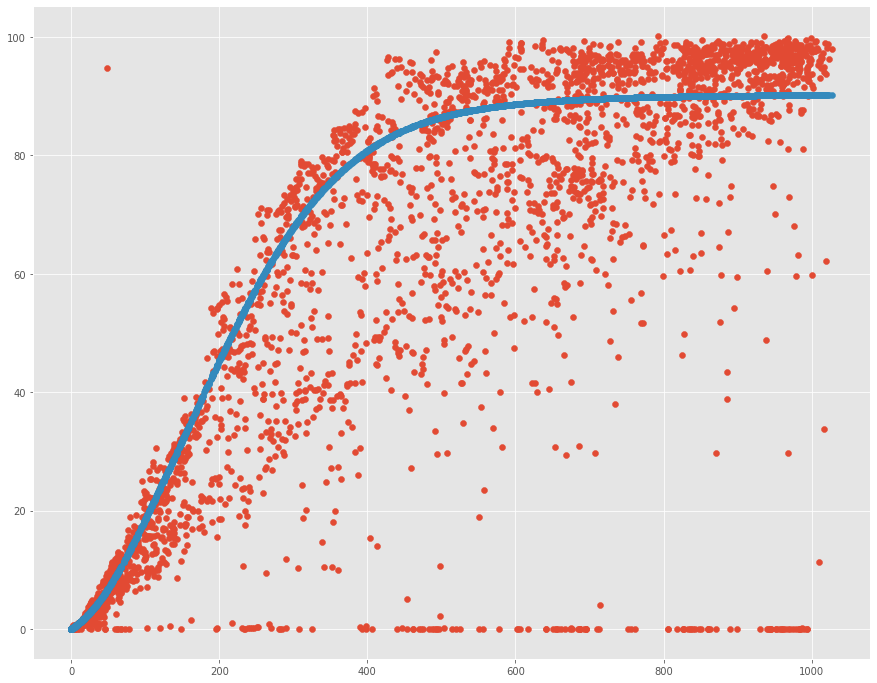

In [93]:
y_est = modelo.predict(x.reshape(-1,1))

plt.figure(figsize=(15, 12))
plt.scatter(x, y)
plt.scatter(x, y_est)

### Paso 7 Revisa y critica el modelo

Si el modelo te gustó y crees que vale la pena mantenerlo, entonces guardalo en disco, y agrega un archivo texto con la explicacion del modelo.

Realiza una funcion ```preprocesamiento_modelo1``` tal que reciba el nombre del archivo y devuelva los datos en la forma que se requiere para poder estimar con tu modelo


In [94]:
def preprocesamiento_modelo1(file):
    """Regresa x, y usados en el modelo1"""
    df = pd.read_excel(url, sheet_name=1)
    df.rename(columns={'Radiacion_FV_W/m2': 'Radiacion_FV'}, inplace=True)
    return df.Radiacion_FV.to_numpy(), df.Generacion_FV_MW.to_numpy()

modelo.save("modelo_1.h5")

nota = """Modelo 1
Entrada: 'Radiacion_FV_W/m2'
Salida: 'Generacion_FV_MW'
"""  

with open('modelo_1.txt', 'w+') as fh:
    fh.write(nota)
    
    

### Paso 8 Prueba un modelo diferente

¿Habrá un mejor modelo? ¿Uno similar con menos parámetros? ¿La selección que se realizó es la correcta en cuanto a método de optimización? ¿Sería bueno agregar regularización?

¿Que pasaria si se toma en cuenta la hora y el día? ¿Y si se consideran valores pasados?